# Topic Modeling: Finding Related Articles

    Creation date : 2020-03-27 (Friday)
    Creator       : Stanislav Schmidt <stanislav.schmidt@epfl.ch>

- Source: [Kaggle :: Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)
- Goals:
    - Study the notebook
    - Understand the underlying techniques
    - Understand the results
    - Usefult for us?
    - What can we add to it to make it better?
    
Related resources:
- Wiki on LDA: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
- YouTube tutorial on LDA: https://www.youtube.com/watch?v=3mHy4OSyRf0
- Sciki-Learn Guide: https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda

## Imports

In [1]:
# pip install --user scispacy
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

In [2]:
from collections import Counter
from itertools import islice
import pathlib

import numpy as np
import pandas as pd
import en_core_sci_md
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import jensenshannon

import matplotlib.pyplot as plt
import seaborn as sb

from tqdm.notebook import tqdm

import ipywidgets as widgets
from IPython.display import HTML, display, clear_output

In [3]:
plt.style.use("dark_background")

In [4]:
log_dir = pathlib.Path() / "1_topic_modeling_lda"
log_dir.mkdir(exist_ok=True)

## Data

In [6]:
df = pd.read_csv(log_dir / 'cord19_df.csv')
df.shape

(29315, 19)

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df.head()

,paper_id,body_text,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,publish_year,link
0,26aec9a28a4345276498c14e302ead7d96c7feee,Here we report a case of a healthy young man p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN
1,252878458973ebf8c4a149447b2887f0e553e7b5,Northern California was evaluated at the Willi...,PMC,Successful Treatment of Disseminated Nocardios...,10.1111/jvim.14855,PMC5787162,29105868.0,cc-by-nc,A 5‐year‐old male castrated Lhasa Apso cross w...,2018 Nov 4 Jan-Feb,"Yaemsiri, S.; Sykes, J.E.",J Vet Intern Med,NaN,NaN,True,noncomm_use_subset,2018,http://dx.doi.org/10.1111/jvim.14855
2,138e18baf12e4e92b67ab7dee321d2b149f236ed,Pneumonia is the leading cause of hospitalizat...,PMC,The changes of prevalence and etiology of pedi...,10.3345/kjp.2017.06100,PMC6172518,30274507.0,cc-by-nc,PURPOSE: Understanding changes in pathogen and...,2018 Sep 15,"Shin, Eun Ju; Kim, Yunsun; Jeong, Jin-Young; J...",Korean J Pediatr,NaN,NaN,True,noncomm_use_subset,2018,http://dx.doi.org/10.3345/kjp.2017.06100
3,e008bb9bd16411df2029bfbfd2df3fef72a7e575,Global climate change is expected to affect th...,PMC,Extreme water-related weather events and water...,10.1017/S0950268812001653,PMC3594835,22877498.0,cc-by-nc-sa,Global climate change is expected to affect th...,2013 Apr 9,"CANN, K. F.; THOMAS, D. Rh.; SALMON, R. L.; WY...",Epidemiol Infect,NaN,NaN,True,noncomm_use_subset,2013,http://dx.doi.org/10.1017/S0950268812001653
4,ba581ccb585036d6220cfb461733c94584326d96,Hand hygiene and patient isolation are two bas...,PMC,Back to basics: hand hygiene and isolation,10.1097/QCO.0000000000000080,PMC4086774,24945613.0,cc-by-nc-nd,PURPOSE OF REVIEW: Hand hygiene and isolation ...,2014 Aug 2,"Lin Huang, G. Khai; Stewardson, Andrew J.; Lin...",Curr Opin Infect Dis,NaN,NaN,True,noncomm_use_subset,2014,http://dx.doi.org/10.1097/QCO.0000000000000080


In [9]:
for c in df.columns:
    print(c)

paper_id
body_text
source_x
title
doi
pmcid
pubmed_id
license
abstract
publish_time
authors
journal
Microsoft Academic Paper ID
WHO #Covidence
has_full_text
full_text_file
publish_year
link


In [61]:
v = tf_vectorizer.transform(["cure for covid-19"])
np.where(v.A)

(array([0, 0]), array([148543, 154401]))

In [63]:
lda_tf.transform(v).argmax()

35

In [64]:
np.unique(lda_tf.transform(v), return_counts=True)

(array([0.00666667, 0.00666667, 0.67333333]), array([48,  1,  1]))

In [10]:
all_texts = df.body_text

In [11]:
all_texts[0][:500]

'Here we report a case of a healthy young man presenting with life threatening diffuse alveolar hemorrhage (DAH) due to leptospirosis pulmonary hemorrhage syndrome (LPHS), acquired during a mud-run. The case is remarkable both in the epidemiologic investigation required to make the diagnosis, and in the use of extracorporeal membrane oxygenation (ECMO) in this infection, which has been reported only once in the United States.\nErnest Goodpasture first described DAH in 1919 in a patient with suspec'

## Tokenize Documentas and Compute Term Frequencies (TF)

For preprocessing we use [scispaCy](https://allenai.github.io/scispacy/), which is a Python package containing [spaCy](https://spacy.io) models for processing biomedical, scientific or clinical text.

In [12]:
nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2_000_000  # maximal number of characters in text

In [13]:
def spacy_tokenizer(sentence):
    return [token.lemma_ for token in nlp(sentence) if not (
        token.like_url or
        token.like_email or
        token.like_num or
        token.is_stop or
        token.is_punct or
        token.is_space or
        token.is_bracket or
        token.is_punct or
        len(token)==1)] # remove numbers (e.g. from references [1], etc.)

In [14]:
example_text = all_texts[0]
example_tokens = spacy_tokenizer(example_text)
example_tokens[:10]

['report',
 'case',
 'healthy',
 'young',
 'man',
 'present',
 'life',
 'threaten',
 'diffuse',
 'alveolar']

In [15]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.',
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [37]:
tf_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800_000) 

tf = tf_vectorizer.fit_transform(tqdm(all_texts))

tf.shape

(29315, 800000)

In [40]:
joblib.dump(tf_vectorizer, 'tf_vectorizer.csv')
joblib.dump(tf, 'tf.csv')

['tf.csv']

In [16]:
# tf_vectorizer = joblib.load(log_dir / 'tf_vectorizer.csv')
# tf = joblib.load(log_dir / 'tf.csv')

In [17]:
feature_names = tf_vectorizer.get_feature_names()

In [18]:
feature_names.index('coronavirus')

146835

In [19]:
feature_names[146835 - 10:146835 + 10]

['coronavirion',
 'coronavirions',
 'coronavirologists',
 'coronavirology',
 'coronavirose',
 'coronaviroses',
 'coronavirosis',
 'coronavirues',
 'coronaviruese',
 'coronavirueses',
 'coronavirus',
 'coronavirus(es',
 'coronavirus,126',
 'coronavirus-',
 'coronavirus-1ike',
 'coronavirus-2',
 'coronavirus-229e',
 'coronavirus-and',
 'coronavirus-antibody',
 'coronavirus-associated']

In [20]:
keyword = 'glyco'
n_show = 20

corona_words_in_features = [word for word in feature_names if keyword in word]
print(f"# {keyword} words:", len(corona_words_in_features))

@widgets.interact(
    i=widgets.IntSlider(
        value=1,
        min=1,
        max=len(corona_words_in_features) // n_show + 1,
        description='Page:'
    )
)
def _(i):
    i_start = (i - 1) * n_show
    i_end = min(i_start + n_show, len(corona_words_in_features))
    
    print("Show entries from {} to {}".format(i_start + 1, i_end))
    print("---")
    for word in corona_words_in_features[i_start:i_end]:
        print(word)
    print("---")

# glyco words: 928


interactive(children=(IntSlider(value=1, description='Page:', max=47, min=1), Output()), _dom_classes=('widget…

<font color='red'>NOTE:</font> the tokens seem to be quite messed up. This might influence the quality of the results

In [21]:
tf.shape

(29315, 800000)

In [22]:
len(all_texts)

29315

How many non-zero entries are there in the count-features?

In [23]:
n_nonzero = (tf != 0).sum()
frac_nonzero = n_nonzero / (tf.shape[0] * tf.shape[1])

print(f"Number of non-zero entries     : {n_nonzero}")
print(f"Percentage of non-zero features: {frac_nonzero * 100:.2f}%")

Number of non-zero entries     : 23423212
Percentage of non-zero features: 0.10%


In [24]:
feature_value_counts = Counter(tf.data)

Distribution of word counts in the features:

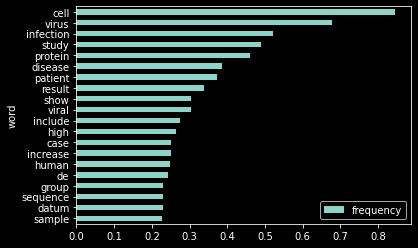

In [25]:
# most frequent words
word_count = pd.DataFrame({
    'word': tf_vectorizer.get_feature_names(),
    'frequency': tf.sum(axis=0).A1 / tf.shape[1]})

word_count.sort_values('frequency', ascending=False)\
          .set_index('word')[:20]\
          .sort_values('frequency', ascending=True)\
          .plot(kind='barh')

## Truncate the vocabulary

**Idea:**
- truncate the most/least frequent words in the vocabulary
- common choice: top 10%, bottom 20%

Inspect the words by their frequency

In [500]:
freqs = tf.sum(axis=0).A1 / tf.shape[1]

In [508]:
freqs_idx = freqs.argsort()
freqs_idx, freqs_idx.shape

(array([     0, 525062, 525061, ..., 284071, 730936, 125653]), (800000,))

In [497]:
feature_names = tf_vectorizer.get_feature_names()

In [499]:
feature_names[730936]

'virus'

In [517]:
idx = freqs_idx[8001]
freqs[idx], feature_names[idx]

(1.25e-06, 'quahty')

## Fit LDA

In [101]:
# this takes long! you can skip this and load the model from the output file
lda_tf = LatentDirichletAllocation(n_components=50, random_state=0) # TODO: tune n_components: how many topics make sense?
lda_tf.fit(tf)
joblib.dump(lda_tf, 'lda.csv')

['lda.csv']

In [26]:
# lda_tf = joblib.load(log_dir / 'lda.csv')

In [102]:
lda2 = LatentDirichletAllocation(n_components=80, random_state=0) # TODO: tune n_components: how many topics make  sense?
lda2.fit(tf)
joblib.dump(lda2, 'lda80.csv')

['lda80.csv']

In [4]:
# lda2 = joblib.load(log_dir / 'lda80.csv')

In [103]:
lda3 = LatentDirichletAllocation(n_components=30, random_state=0) # TODO: tune n_components: how many topics make sense?
lda3.fit(tf)
joblib.dump(lda3, 'lda30.csv')

['lda30.csv']

In [3]:
# lda3 = joblib.load(log_dir / 'lda30.csv')

In [27]:
lda_tf

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## Discovered Topics

Inspect the topic composition of a number of documents

In [169]:
t = lda_tf.transform(tf[:20]).T
t.shape  # (n_topics, n_documents)

(50, 20)

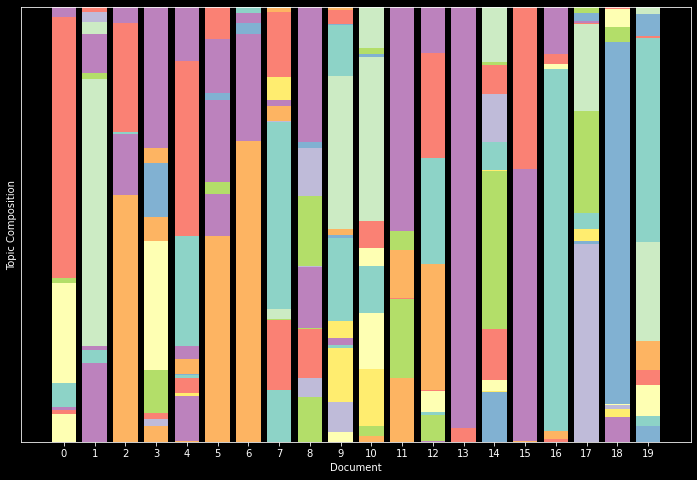

In [175]:
plt.figure(figsize=(12, 8))
x_vals = range(t.shape[1])
for i, (values, bottom) in enumerate(zip(t, np.cumsum(t, axis=0) - t)):
    plt.bar(x_vals, values, bottom=bottom)
#     break
plt.xlabel("Document")
plt.ylabel("Topic Composition")
plt.xticks(x_vals)
plt.yticks([])
plt.show()

Apply LDA to all documents to compute the topic distributions

In [179]:
# slow, load from output file instead
topic_dist_arr = lda_tf.transform(tf)
topic_dist = pd.DataFrame(topic_dist_arr)
topic_dist.to_csv('topic_dist.csv', index=False)

In [638]:
# Load from output file
# topic_dist = pd.read_csv('topic_dist.csv')

In [181]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000016,0.063052,0.000016,0.009705,0.000016,0.000016,0.000016,0.006290,0.000016,0.000016,...,0.000016,0.000016,0.000016,0.598568,0.000016,0.000016,0.000016,0.023403,0.000016,0.000016
1,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.180188,0.000012,0.000012,...,0.000012,0.000012,0.021483,0.012599,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
2,0.000013,0.000013,0.000013,0.000013,0.000013,0.566414,0.000013,0.076140,0.000013,0.000013,...,0.000013,0.000013,0.000013,0.252351,0.000013,0.000013,0.000013,0.035968,0.000013,0.000013
3,0.000008,0.000008,0.000008,0.000008,0.000008,0.035569,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.324324,0.000008,0.000008
4,0.000011,0.000011,0.000011,0.000011,0.000011,0.002228,0.000011,0.104095,0.000011,0.004745,...,0.252573,0.000011,0.000011,0.401539,0.000011,0.000011,0.000011,0.124437,0.000011,0.000011


Print samples for all topics

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [176]:
tfidf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tfidf_feature_names, 25)


Topic #0: study asthma child patient symptom airway exacerbation group treatment subject nasal copd year increase effect allergic respiratory age cold trial wheeze acute associate level day

Topic #1: cell cause disease occur lesion tissue intestinal include small associate result usually increase mucosa live infection common chronic epithelium inflammation normal present case large form

Topic #2: increase effect study receptor cell level role rat expression mouse function activity signal activation disease protein cancer suggest brain show model factor mechanism pathway decrease

Topic #3: tourism market travel price industry hong passenger kong airport effect tourist economic result impact cost hotel study air country business event crisis airline demand destination

Topic #4: un che con sono nel alla più ha cd13 cftr tra gli degli come rischio ad ed pazienti nella nei essere stato studio salute anche

Topic #5: study age case child year infection report high disease risk rate infa

By manual inspection of the topics we see that there are some articles in languages other than English:
- #4 = Italian
- #8 = French
- #11 = Spanish
- #41 = German

Determine how many documents there are that are assigned to the language topics, and show a preview

In [255]:
language_topics = {
    'Italian': 4,
    'French': 8,
    'Spanish': 11,
    'German': 41,
}

In [324]:
def count_docs_by_language_topic(top_n_topics=1):
    for lang, lang_topic_idx in language_topics.items():
        top_n = topic_dist_arr.argsort(axis=1)[:, -top_n_topics:]
        doc_mask = np.sum(top_n == lang_topic_idx, axis=1).sum()
        print(f"{lang:10s}: {doc_mask.sum():3d}")
            

count_docs_by_language_topic(top_n_topics=1)

Italian   :  17
French    : 321
Spanish   : 281
German    :  54


Preview widget by language

In [368]:
@interact(
    lang_topic_idx=widgets.Dropdown(
        options=language_topics,
        description='Language'),
    top_n_topics=widgets.IntSlider(
        value=1,
        min=1,
        max=topic_dist_arr.shape[1],
        description='Top N topics'),
)
def preview_docs_by_language(lang_topic_idx, top_n_topics):
    top_n = topic_dist_arr.argsort(axis=1)[:, -top_n_topics:]
    doc_mask = np.sum(top_n == lang_topic_idx, axis=1)
    doc_ids = np.where(doc_mask)[0]
    n_docs = len(doc_ids)
    print(f">>> {n_docs} documents found")
    per_page=20
    n_pages = np.ceil(n_docs / per_page).astype(int)
    @interact(
        which_page=widgets.IntSlider(
            value=1,
            min=1,
            max=n_pages,
            description=f"Page (of {n_pages})",
        ),
    )
    def show_page(which_page):
        n_start = (which_page - 1) * per_page
        n_end = n_start + per_page
        ids = doc_ids[n_start:n_end]
        for i, idx in enumerate(ids):
            text = all_texts[idx][:80].replace('\n', ' ')
            print(f"# {n_start + i+1:2d}: {text} [...]")

interactive(children=(Dropdown(description='Language', options={'Italian': 4, 'French': 8, 'Spanish': 11, 'Ger…

## Get Nearest Papers (in Topic Space)

In [33]:
convid19_kw = [
    'COVID-19',
    'SARS-CoV-2',
    '2019-nCov',
    'SARS Coronavirus 2',
    '2019 Novel Coronavirus',
]
df['is_covid19_article'] = df.body_text.str.contains('|'.join(convid19_kw), case=False)

In [36]:
def get_k_nearest_docs(
    doc_dist,
    k=5,
    lower=1950,
    upper=2020,
    only_covid19=False,
    get_dist=False):
    
    """Given a document LDA distribution determine the k nearest documents
    
    Parameters
    ----------
    doc_dist : array_like
        topic distribution (sums to 1) of one article
    
    Return
    ------
    Returns the index of the k nearest articles (as by Jensen–Shannon
    divergence in topic space). 
    """
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        topic_dist_temp = topic_dist[relevant_time & df.is_covid19_article]
    else:
        topic_dist_temp = topic_dist[relevant_time]
         
    distances = topic_dist_temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_distances = distances[distances != 0].nsmallest(n=k)
    k_nearest = k_distances.index
    
    if get_dist:
        return k_nearest, k_distances
    else:
        return k_nearest

In [39]:
d = get_k_nearest_docs(topic_dist[df.paper_id == '90b5ecf991032f3918ad43b252e17d1171b4ea63'].iloc[0])
d
# sb.kdeplot(d)

Int64Index([2398, 2993, 10412, 2852, 2737], dtype='int64')

In [40]:
def plot_article_dna(paper_id, width=12):
    t = df[df.paper_id == paper_id].title.values[0]
    topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 5))
    plt.xlabel('Topic')

    
def compare_dnas(paper_id, recommendation_id, width=12):
    t = df[df.paper_id == recommendation_id].title.values[0]
    title_max_len = 100
    if len(t) > title_max_len - 6:
        t = t[:title_max_len - 6] + " [...]"
    temp = topic_dist[df.paper_id == paper_id]
    temp = pd.concat([temp, topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 5), ylim= [0, 1])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])
    plt.show()

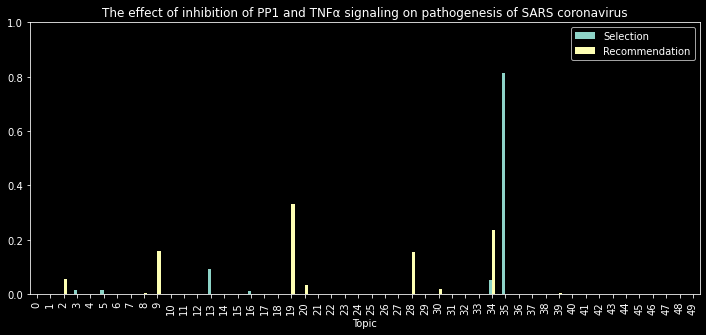

In [41]:
compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

## Search related papers to a chosen one

In [385]:
def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

            
def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            compare_dnas(paper_id, recommendation_ids[i])

In [386]:
def recommendation(paper_id, k=5, lower=1950, upper=2020, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    
    print(df.title[df.paper_id == paper_id].values[0])

    recommended, dist = get_k_nearest_docs(topic_dist[df.paper_id == paper_id].iloc[0], k, lower, upper, only_covid19, get_dist=True)
    recommended = df.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['link','title', 'similarity']].values])
    display(HTML(h))
    
    if plot_dna:
        compare_tabs(paper_id, recommended.paper_id.values)

In [443]:
recommendation(
    'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a',
    k=5,
    lower=2005,
    upper=2018,
    only_covid19=False,
    plot_dna=True)

The effect of inhibition of PP1 and TNFα signaling on pathogenesis of SARS coronavirus


In [388]:
recommendation('a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a', k=5, only_covid19=True, plot_dna=True)

The effect of inhibition of PP1 and TNFα signaling on pathogenesis of SARS coronavirus


In [205]:
recommendation('90b5ecf991032f3918ad43b252e17d1171b4ea63', k=5, only_covid19=False, plot_dna=True)

The role of absolute humidity on transmission rates of the COVID-19 outbreak


In [206]:
recommendation('c04c7fb330a409a00f67040dde0f83b3da88eacb', k=5, only_covid19=True, plot_dna=True)

Potential inhibitors for 2019-nCoV coronavirus M protease from clinically approved medicines


In [207]:
recommendation('36521caf90f471c9da1a4e84f8562440d73ead9a', k=5, plot_dna=True)

Estimation of the epidemic properties of the 2019 novel coronavirus: A mathematical modeling study


## Widget: Pick a COVID-19-Paper

In [28]:
def related_papers():
    """
    Creates a widget where you can select one of many papers about covid-19
    and then displays related articles from the whole dataset.
    """
    covid_query = 'COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus'  # are there more names?
    covid_papers = df[df.body_text.str.contains(covid_query)][['paper_id', 'title']]
    title_to_id = covid_papers.set_index('title')['paper_id'].to_dict()
    
    def main_function(bullet, k=5, year_range=[1950, 2020], only_covid19=False):
        recommendation(
            title_to_id[bullet],
            k,
            lower=year_range[0],
            upper=year_range[1],
            only_covid19=only_covid19)
    
    yearW = widgets.IntRangeSlider(
        min=1950,
        max=2020,
        value=[2010, 2020],
        description='Year Range',
        continuous_update=False,
        layout=widgets.Layout(width='40%'))
    covidW = widgets.Checkbox(
        value=False,
        description='Only COVID-19-Papers',
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='20%'))
    kWidget = widgets.IntSlider(
        value=10,
        description='k',
        max=50,
        min=1,
        layout=widgets.Layout(width='20%'),
        continuous_uptdate=False)
    bulletW = widgets.Select(
        options=title_to_id.keys(),
        layout=widgets.Layout(width='90%', height='200px'),
        description='Title:')
    widget = widgets.interactive(
        main_function,
        bullet=bulletW,
        k=kWidget,
        year_range=yearW,
        only_covid19=covidW)

    controls = widgets.VBox(
        [
            widgets.Box(
                children=[
                    widget.children[:-1][1],
                    widget.children[:-1][2],
                    widget.children[:-1][3]],
                layout=widgets.Layout(justify_content='space-around')),
            widget.children[:-1][0]
        ])
    output = widget.children[-1]
    display(widgets.VBox([controls, output]))

In [29]:
related_papers()

## Browse Tasks

We can now also map a task or bullet point into the topic space and find related articles that might help to solve the question at hand.

Note: Some of the bullet points are very short - results might not be reliable in this case.

In [30]:
task1 = [
    "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
"Seasonality of transmission.",
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
"Natural history of the virus and shedding of it from an infected person",
"Implementation of diagnostics and products to improve clinical processes",
"Disease models, including animal models for infection, disease and transmission",
"Tools and studies to monitor phenotypic change and potential adaptation of the virus",
"Immune response and immunity",
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
"Role of the environment in transmission"]

task2 = ['Data on potential risks factors',
'Smoking, pre-existing pulmonary disease',
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
'Neonates and pregnant women',
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors', 
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
'Susceptibility of populations',
'Public health mitigation measures that could be effective for control']

task3 = ['Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.',
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
'Experimental infections to test host range for this pathogen.',
'Animal host(s) and any evidence of continued spill-over to humans',
'Socioeconomic and behavioral risk factors for this spill-over',
'Sustainable risk reduction strategies']

task4 = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

task5 = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
"Exploration of use of best animal models and their predictive value for a human vaccine.",
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
"Efforts targeted at a universal coronavirus vaccine.",
"Efforts to develop animal models and standardize challenge studies",
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
"Approaches to evaluate risk for enhanced disease after vaccination",
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"]

task6 = ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019", 
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
"Efforts to support sustained education, access, and capacity building in the area of ethics",
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

task7 = ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
"Policies and protocols for screening and testing.",
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
"Technology roadmap for diagnostics.",
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
"Coupling genomics and diagnostic testing on a large scale.",
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]

task8 = ["Resources to support skilled nursing facilities and long term care facilities.",
"Mobilization of surge medical staff to address shortages in overwhelmed communities",
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
"Guidance on the simple things people can do at home to take care of sick people and manage disease.",
"Oral medications that might potentially work.",
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

task9 = ["Methods for coordinating data-gathering with standardized nomenclature.",
"Sharing response information among planners, providers, and others.",
"Understanding and mitigating barriers to information-sharing.",
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
"Integration of federal/state/local public health surveillance systems.",
"Value of investments in baseline public health response infrastructure preparedness",
"Modes of communicating with target high-risk populations (elderly, health care workers).",
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
"Communication that indicates potential risk of disease to all population groups.",
"Misunderstanding around containment and mitigation.",
"Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
"Measures to reach marginalized and disadvantaged populations.",
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

tasks={'What is known about transmission, incubation, and environmental stability?': task1,
       'What do we know about COVID-19 risk factors?': task2, 
       'What do we know about virus genetics, origin, and evolution?': task3, 
       'What do we know about non-pharmaceutical interventions?': task4,
       'What do we know about vaccines and therapeutics?': task5, 
       'What has been published about ethical and social science considerations?': task6, 
       'What do we know about diagnostics and surveillance?': task7,
       'What has been published about medical care?': task8, 
       'What has been published about information sharing and inter-sectoral collaboration?': task9}

In [31]:
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_tf = tf_vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda_tf.transform(tasks_tf))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(
            tasks_topic_dist.iloc[index],
            k,
            lower,
            upper,
            only_covid19)
        recommended = df.iloc[recommended]

        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>'
                          for l, n in recommended[['link','title']].values])
        display(HTML(h))

### What is known about transmission, incubation, and environmental stability?

In [42]:
relevant_articles(task1, 5, only_covid19=True)

Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.


Prevalence of asymptomatic shedding and transmission (e.g., particularly children).


Seasonality of transmission.


Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).


Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).


Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).


Natural history of the virus and shedding of it from an infected person


Implementation of diagnostics and products to improve clinical processes


Disease models, including animal models for infection, disease and transmission


Tools and studies to monitor phenotypic change and potential adaptation of the virus


Immune response and immunity


Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings


Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings


Role of the environment in transmission


### What do we know about COVID-19 risk factors?

In [222]:
relevant_articles(task2, 5, only_covid19=True)

Data on potential risks factors


Smoking, pre-existing pulmonary disease


Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities


Neonates and pregnant women


Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.


Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors


Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups


Susceptibility of populations


Public health mitigation measures that could be effective for control


### What do we know about virus genetics, origin, and evolution?

In [223]:
relevant_articles(task3, 5, only_covid19=True)

Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.


Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.


Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.


Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.


Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.


Experimental infections to test host range for this pathogen.


Animal host(s) and any evidence of continued spill-over to humans


Socioeconomic and behavioral risk factors for this spill-over


Sustainable risk reduction strategies


### What do we know about non-pharmaceutical interventions?

In [224]:
relevant_articles(task4, 5, only_covid19=True)

Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.


Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.


Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.


Methods to control the spread in communities, barriers to compliance and how these vary among different populations..


Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.


Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.


Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).


Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay.


### What do we know about vaccines and therapeutics?

In [225]:
relevant_articles(task5, 5, only_covid19=True)

Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.


Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.


Exploration of use of best animal models and their predictive value for a human vaccine.


Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.


Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.


Efforts targeted at a universal coronavirus vaccine.


Efforts to develop animal models and standardize challenge studies


Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers


Approaches to evaluate risk for enhanced disease after vaccination


Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]


### What has been published about ethical and social science considerations?

In [226]:
relevant_articles(task6, 5, only_covid19=True)

Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019


Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight


Efforts to support sustained education, access, and capacity building in the area of ethics


Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.


Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)


Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.


Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media.


### What do we know about diagnostics and surveillance?

In [227]:
relevant_articles(task7, 5, only_covid19=True)

How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).


Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.


Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.


National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).


Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.


Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).


Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.


Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.


Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.


Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.


Policies and protocols for screening and testing.


Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.


Technology roadmap for diagnostics.


Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.


New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.


Coupling genomics and diagnostic testing on a large scale.


Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.


Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.


One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors.


### What has been published about medical care?

In [228]:
relevant_articles(task8, 5, only_covid19=True)

Resources to support skilled nursing facilities and long term care facilities.


Mobilization of surge medical staff to address shortages in overwhelmed communities


Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies


Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients


Outcomes data for COVID-19 after mechanical ventilation adjusted for age.


Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.


Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.


Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.


Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.


Guidance on the simple things people can do at home to take care of sick people and manage disease.


Oral medications that might potentially work.


Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.


Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.


Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials


Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials


Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)


### What has been published about information sharing and inter-sectoral collaboration?

In [229]:
relevant_articles(task9, 5, only_covid19=True)

Methods for coordinating data-gathering with standardized nomenclature.


Sharing response information among planners, providers, and others.


Understanding and mitigating barriers to information-sharing.


How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).


Integration of federal/state/local public health surveillance systems.


Value of investments in baseline public health response infrastructure preparedness


Modes of communicating with target high-risk populations (elderly, health care workers).


Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).


Communication that indicates potential risk of disease to all population groups.


Misunderstanding around containment and mitigation.


Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.


Measures to reach marginalized and disadvantaged populations.


Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.


Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.


Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care


## Widget: Pick a Task

In [43]:
def relevant_articles_for_task():
    def main_function(bullet, task, k=5, year_range=[1950, 2020], only_covid19=False):
        relevant_articles([bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
        bulletW.options = tasks[task]    

    yearW = widgets.IntRangeSlider(
        min=1950,
        max=2020,
        value=[2010, 2020],
        description='Year Range',
        continuous_update=False,
        layout=widgets.Layout(width='40%'))
    covidW = widgets.Checkbox(
        value=True,
        description='Only COVID-19-Papers',
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='20%'))
    kWidget = widgets.IntSlider(
        value=10,
        description='k',
        max=50,
        min=1,
        layout=widgets.Layout(width='30%'))
    taskW = widgets.Dropdown(
        options=tasks.keys(),
        layout=widgets.Layout(width='90%', height='50px'),
        description='Task:')
    init = taskW.value
    bulletW = widgets.Select(
        options=tasks[init],
        layout=widgets.Layout(width='90%', height='200px'),
        description='Bullet Point:')
    widget = widgets.interactive(
        main_function,
        task=taskW,
        bullet=bulletW,
        k=kWidget,
        year_range=yearW,
        only_covid19=covidW)
    
    controls = widgets.VBox(
        [
            widgets.HBox(
                [
                    widget.children[2],
                    widget.children[3],
                    widget.children[4]
                ],
                layout=widgets.Layout(width='90%', justify_content='space-around')),
            widget.children[1],
            widget.children[0]
        ],
        layout=widgets.Layout(align_items='center'))
    output = widget.children[-1]
    
    display(widgets.VBox([controls, output]))

In [44]:
relevant_articles_for_task()

## Widget: Free Text Search with exclusions

In [605]:
doc_tf = exclusions_tf = tf_vectorizer.transform(['honey'])
exclusions_tf = tf_vectorizer.transform(['traditional'])

In [606]:
topic_dist = pd.DataFrame(lda_tf.transform(doc_tf))
exclusions_topic_dist = pd.DataFrame(lda_tf.transform(exclusions_tf))

In [38]:
# topic_dist = pd.read_csv(log_dir / 'topic_dist.csv')

In [604]:
dds = topic_dist.apply(lambda x: jensenshannon(x, exclusions_topic_dist.iloc[0]), axis=1)

In [637]:
topic_dist.nsmallest()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [687]:
def get_k_nearest_docs(
    doc_dist,
    excl_dist=None,
    k=5,
    lower=1950,
    upper=2020,
    only_covid19=False,
    get_dist=False,
    get_original_dist=False):
    
    """Given a document LDA distribution determine the k nearest documents
    
    Parameters
    ----------
    doc_dist : array_like
        topic distribution (sums to 1) of one article
    
    Return
    ------
    Returns the index of the k nearest articles (as by Jensen–Shannon
    divergence in topic space). 
    """
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        topic_dist_temp = topic_dist[relevant_time & df.is_covid19_article]
    else:
        topic_dist_temp = topic_dist[relevant_time]
        
         
    distances = topic_dist_temp.apply(
        lambda x: jensenshannon(x, doc_dist), axis=1)
    distances[distances == 0] = 100  # exclude itself
    
    if excl_dist is None:
        distances_excl = topic_dist_temp.apply(
            lambda x: 0.0, axis=1)
    else:
        distances_excl = topic_dist_temp.apply(
            lambda x: jensenshannon(x, excl_dist), axis=1)
    
    
    
    
    relative_distances = distances - distances_excl
    
    k_distances = relative_distances.nsmallest(n=k)
    k_nearest = k_distances.index
    
    if get_dist and not get_original_dist:
        return k_nearest, k_distances
    elif get_dist and get_original_dist:
        return k_nearest, k_distances, distances[k_nearest], distances_excl[k_nearest]
    else:
        return k_nearest

In [733]:
def get_k_nearest_single(
    query_doc_distr,
    exclusion_doc_distr=None,
    k=3,
    lower=1950,
    upper=2020,
    only_covid19=False):
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        topic_dist_temp = topic_dist[relevant_time & df.is_covid19_article]
    else:
        topic_dist_temp = topic_dist[relevant_time]
    
    distances = topic_dist_temp.apply(
        lambda x: jensenshannon(x, query_doc_distr), axis=1)
    distances[distances == 0] = 100  # exclude itself
    
    if exclusion_doc_distr is not None:
        distances_excl = topic_dist_temp.apply(
            lambda x: jensenshannon(x, exclusion_doc_distr), axis=1)
    else:
        distances_excl = pd.Series(0, index=distances.index)
    
    
    relative_distances = distances - distances_excl
    k_distances = relative_distances.nsmallest(n=k)
    k_nearest = k_distances.index
    
    return k_nearest, k_distances, distances[k_nearest], distances_excl[k_nearest]

In [734]:
def relevant_articles_single(query_doc, exlusion_doc=None, k=3, lower=1950, upper=2020, only_covid19=False):
    print("Query      :", query_doc)
    print("Exclusions :", exlusion_doc)
    
    query_tf = tf_vectorizer.transform([query_doc])
    query_topic_distr = lda_tf.transform(query_tf)[0]
    
    if exlusion_doc is not None and len(exlusion_doc) > 0:
        exclusion_tf = tf_vectorizer.transform([exlusion_doc])
        exclusion_topic_distr = lda_tf.transform(exclusion_tf)[0]
    else:
        exclusion_topic_distr = None
    
    recommended, distances, d_tasks, d_excl = get_k_nearest_single(
        query_topic_distr,
        exclusion_topic_distr,
        k,
        lower,
        upper,
        only_covid19)

    lines = []
    for idx, dist, dt, de in zip(recommended, distances, d_tasks, d_excl):
        link = df.iloc[idx]['link']
        title = df.iloc[idx]['title']
        line = f"[sim={dist:.2f}={dt:.2f}-{de:.2f}] <a href={link} target='_blank'>{title}</a>"
        lines.append(line)

    h = '<br/>'.join(lines)
    display(HTML(h))

In [737]:
relevant_articles_single('honey', k=10)

Query      : honey
Exclusions : None


In [753]:
lda_tf.transform(tf_vectorizer.transform(['glucose']))

array([[0.01, 0.01, 0.51, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [754]:
lda_tf.transform(tf_vectorizer.transform(['diabetes']))

array([[0.01, 0.01, 0.51, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [755]:
relevant_articles_single('glucose', 'diabetes', k=10)

Query      : glucose
Exclusions : diabetes


In [688]:
def relevant_articles(tasks, exclusions=None, k=3, lower=1950, upper=2020, only_covid19=False):
    tasks = [tasks] if type(tasks) is str else tasks
    if exclusions is None:
        exclusions = ['']
    elif type(exclusions) is str:
        exclusions = [exclusions]
    
    tasks_tf = tf_vectorizer.transform(tasks)
    exclusions_tf = tf_vectorizer.transform(exclusions)
    
    tasks_topic_dist = pd.DataFrame(lda_tf.transform(tasks_tf))
    exclusions_topic_dist = pd.DataFrame(lda_tf.transform(exclusions_tf))

    for index, (bullet, exclusion) in enumerate(zip(tasks, exclusions)):
        print("Query      :", bullet)
        print("Exclusions :", exclusion)
        recommended, distances, d_tasks, d_excl = get_k_nearest_docs(
            tasks_topic_dist.iloc[index],
            exclusions_topic_dist.iloc[index],
            k,
            lower,
            upper,
            only_covid19,
            get_dist=True,
            get_original_dist=True)
        
        lines = []
        for idx, dist, dt, de in zip(recommended, distances, d_tasks, d_excl):
            link = df.iloc[idx]['link']
            title = df.iloc[idx]['title']
            line = f"[sim={dist:.2f}={dt:.2f}-{de:.2f}] <a href={link} target='_blank'>{title}</a>"
            lines.append(line)
        
        h = '<br/>'.join(lines)
        display(HTML(h))

In [689]:
relevant_articles("honey", exclusions=None, k=5)

Query      : honey
Exclusions : 


In [248]:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=widgets.Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                               continuous_update=False, layout=widgets.Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=widgets.Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=widgets.Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(widgets.VBox([widgets.HBox([kWidget, yearW, covidW], layout=widgets.Layout(width='90%', justify_content='space-around')),
        textW, button], layout=widgets.Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(widgets.VBox([widgets.HBox([kWidget, yearW, covidW], layout=widgets.Layout(width='90%', justify_content='space-around')),
            textW, button], layout=widgets.Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

In [249]:
relevant_articles_for_text()

cure for covid-19


## Widget: Free Text Search

In [45]:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=widgets.Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                               continuous_update=False, layout=widgets.Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=widgets.Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=widgets.Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(widgets.VBox([widgets.HBox([kWidget, yearW, covidW], layout=widgets.Layout(width='90%', justify_content='space-around')),
        textW, button], layout=widgets.Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(widgets.VBox([widgets.HBox([kWidget, yearW, covidW], layout=widgets.Layout(width='90%', justify_content='space-around')),
            textW, button], layout=widgets.Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

In [46]:
relevant_articles_for_text()

cure for covid-19


## The End

Where can one improve:

- [ ] Remove papers with foreign languages
- [ ] Better vocabulary
    - compund words / synonyms
    - truncate top/bottom n%
- [ ] play with n_topics
- [x] make queries faster

## Sandbox

In [68]:
query = "cure for covid-19"
top_title = "Quantifying dynamics of SARS-CoV-2 transmission suggests that epidemic control and avoidance is feasible through instantaneous digital contact tracing"
top_sha = "c91b581d38243c502118d93fc6f71ee02ec395e4"

In [67]:
df[df.title == top_title]

,paper_id,body_text,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,publish_year,link,is_covid19_article
2915,c91b581d38243c502118d93fc6f71ee02ec395e4,The new viral pathogen SARS-CoV-2 emerged in l...,medrxiv,Quantifying dynamics of SARS-CoV-2 transmissio...,10.1101/2020.03.08.20032946,NaN,NaN,medrvix,Mobile phone apps implementing algorithmic con...,2020-03-12,Luca Ferretti; Chris Wymant; Michelle Kendall;...,NaN,NaN,NaN,True,biorxiv_medrxiv,2020,http://dx.doi.org/10.1101/2020.03.08.20032946,True


In [82]:
query_distr = lda_tf.transform(tf_vectorizer.transform([query]))[0]

In [83]:
query_distr

array([0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.67333333, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667])

In [78]:
top_doc_distr = topic_dist.iloc[2915].values
top_doc_distr

array([9.85707245e-06, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 1.01268429e-02, 9.85707245e-06, 9.85707245e-06,
       2.02473331e-03, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 1.39728165e-02, 9.85707245e-06, 3.00036303e-03,
       9.85707245e-06, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 9.85707245e-06, 4.46405899e-03, 9.85707245e-06,
       9.85707245e-06, 9.85707245e-06, 1.18699184e-02, 9.30979012e-01,
       9.85707245e-06, 9.85707245e-06, 3.80413464e-03, 9.85707245e-06,
       1.59768454e-02, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       9.85707245e-06, 9.85707245e-06, 9.85707245e-06, 9.85707245e-06,
       3.38699203e-03, 9.85707245e-06])

In [85]:
jensenshannon(top_doc_distr, query_distr)

0.32442223674872517

In [86]:
other_top_sha = 'a50f3a7514dd9363e42a1eff725a7eb3e49b6ed2'

In [87]:
df[df.paper_id == other_top_sha]

,paper_id,body_text,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,publish_year,link,is_covid19_article
9888,a50f3a7514dd9363e42a1eff725a7eb3e49b6ed2,1 Supporting Text S1 infection (relative to co...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,False


In [90]:
jensenshannon(top_doc_distr, topic_dist.iloc[9888])

0.21536620682174096

In [91]:
df[df.paper_id == '2309dc999803317771dca7201f28e8632b8bf773']

,paper_id,body_text,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,publish_year,link,is_covid19_article
17305,2309dc999803317771dca7201f28e8632b8bf773,veals the epidemic in Hubei is much more serio...,Elsevier,Trend and forecasting of the COVID-19 outbreak...,10.1016/j.jinf.2020.02.014,NaN,NaN,els-covid,NaN,2020-02-27,"Li, Qiang; Feng, Wei; Quan, Ying-Hui",Journal of Infection,3.005902e+09,#2988,True,custom_license,2020,http://dx.doi.org/10.1016/j.jinf.2020.02.014,True
